In [2]:
import os.path as op
import matplotlib.pyplot as plt
import socket
import torch
from torch.utils.data import DataLoader
import logging
from dataset import DataloaderImg, GreyToRGB, NormalizeVolume
from torch import optim
import torchvision.transforms.v2 as tfms
from tqdm import tqdm
from torch.utils import tensorboard
from summary import summary_grid, show_batch
from loss import DiceLoss

plt.ion()  # interactive mode

# install pytorch correctly
# https://discuss.pytorch.org/t/torch-cuda-is-not-available/74845/11

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
logging.basicConfig(
    level=logging.INFO,
)
# install cuda driver ubuntu
# https://ubuntu.com/server/docs/nvidia-drivers-installation

cuda


In [3]:
# https://pytorch.org/docs/stable/cuda.html
# torch.cuda.is_initialized()

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current cuda device: {torch.cuda.get_device_name(current_device)}")

Current cuda device: NVIDIA RTX A2000


In [4]:
# script for segmentation
# https://github.com/mateuszbuda/brain-segmentation-pytorch

In [5]:
# help in loading images
# https://discuss.pytorch.org/t/how-to-load-all-the-nii-from-the-directory-without-augmentation-using-pytorch-dataloader/60938/3
root_dir = "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction"  #!NOTE: delete "/train" for all subjects

custom_transforms = [NormalizeVolume(), GreyToRGB()]
transforms = [tfms.RandomRotation(180)]
n_validation = 4
# full_dataset = Dataloder_img('C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1', 'C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1/ADNI_136_S_0300_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080529142830882_S50401_I107759.nii' ,tfms.Compose([tfms.RandomRotation(180).tfms.ToTensor()]))
train_dataset = DataloaderImg(
    root_dir,
    subset="train",
    validation_cases=n_validation,
    custom_transforms=custom_transforms,
    transforms=transforms,
)
validation_dataset = DataloaderImg(
    root_dir,
    subset="validation",
    validation_cases=n_validation,
    custom_transforms=custom_transforms,
    transforms=transforms,
)

loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

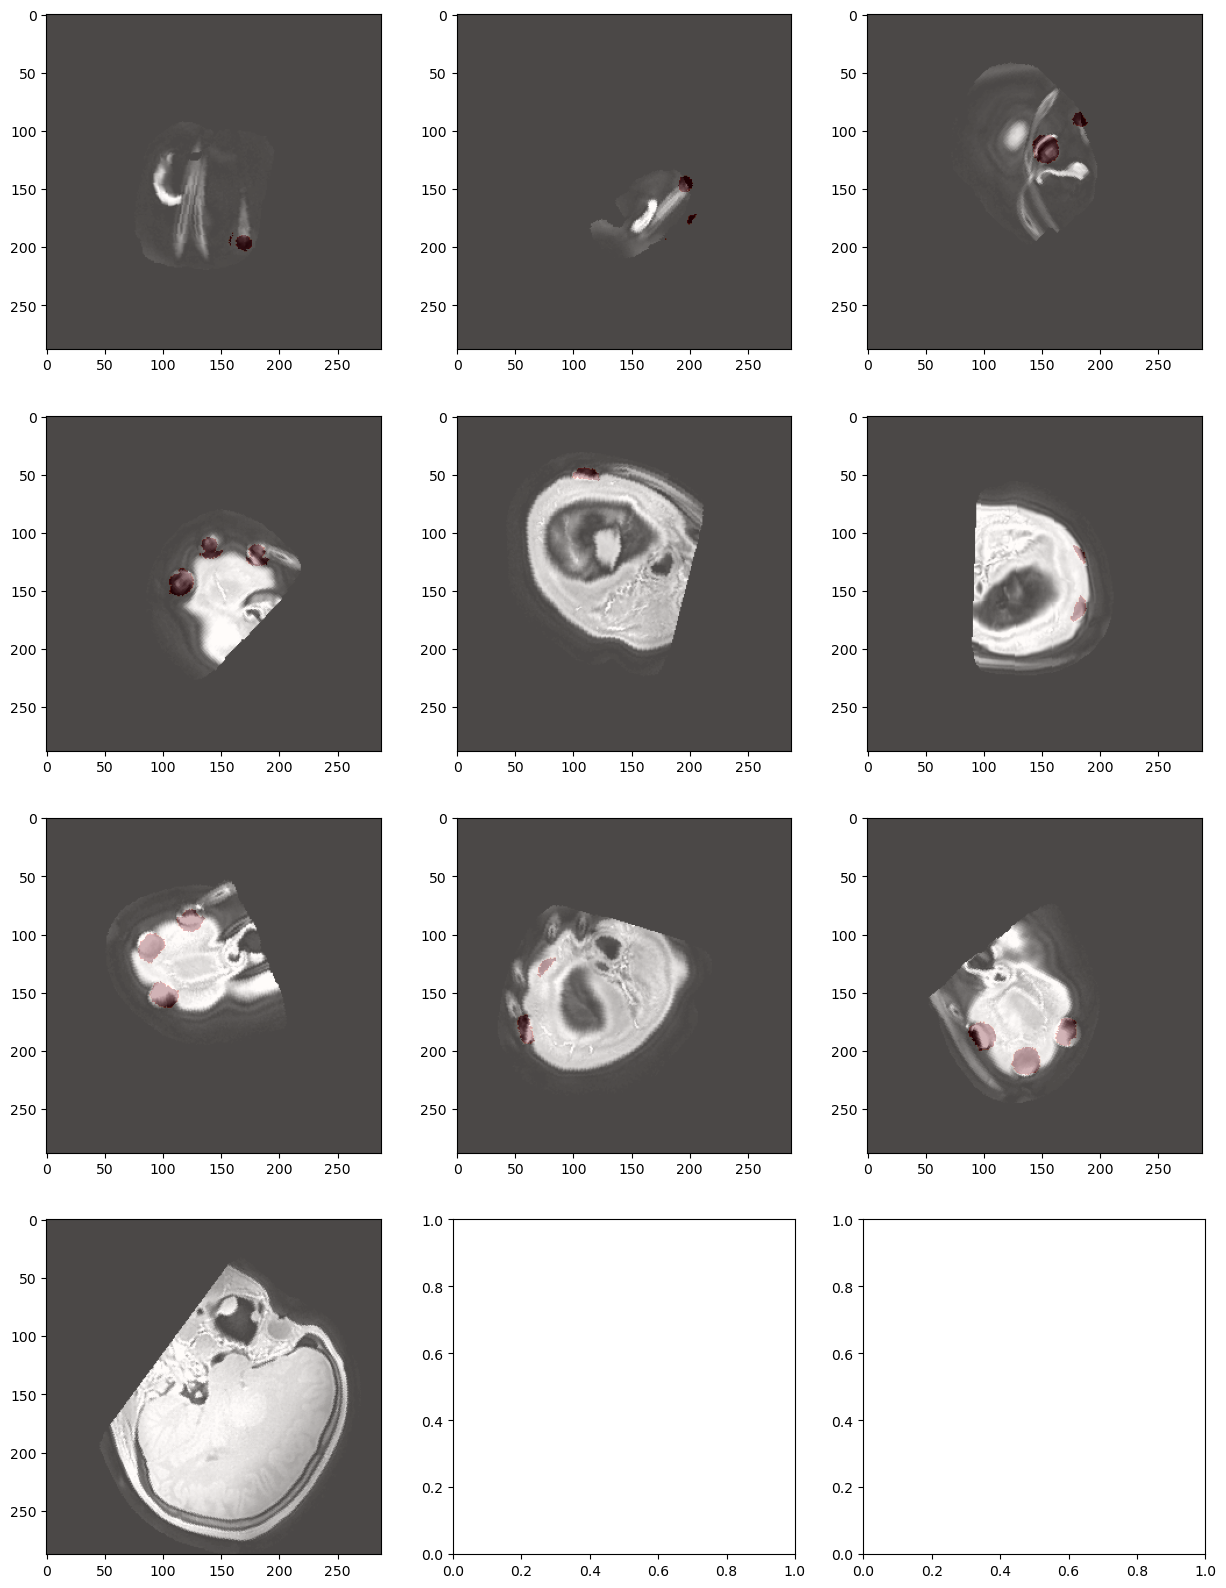

In [6]:
train_img, train_mask = next(iter(loader))
show_batch(train_img, train_mask)
plt.show()

In [7]:
unet = torch.hub.load(
    "mateuszbuda/brain-segmentation-pytorch",
    "unet",
    in_channels=3,
    out_channels=1,
    init_features=32,
    pretrained=False,
)

Using cache found in /home/riemanns/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Check free GPU memory with `nvtop` in the terminal


In [8]:
unet.to(device)

batch_size = 16
if (socket.gethostname() == "Linux-Meinzer2") and (batch_size > 17):
    raise ValueError("Batch size too large for Linux-Meinzer2")
phase = "train"
epochs = 200
img_freq = 10
lr = 2e-3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

loaders = {"train": train_loader, "valid": valid_loader}

dsc_loss = DiceLoss()
best_validation_dsc = 0.0

optimizer = optim.Adam(unet.parameters(), lr=lr)

loss_train = []

step = 0

writer = tensorboard.SummaryWriter()

for _ in tqdm(range(epochs), total=epochs):
    unet.train()

    validation_pred = []
    validation_true = []

    for i, data in enumerate(loaders[phase]):
        step += 1

        x, y_true = data
        x, y_true = x.to(device, dtype=torch.float), y_true.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
            y_pred = unet(x)
            loss = dsc_loss(y_pred, y_true)

            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

            writer.add_scalar("loss/train", loss.item(), step)

        if step % img_freq != 0:
            continue

        writer.add_figure(
            f"step {step}: predictions vs. petra",
            summary_grid(x.cpu().detach().type(torch.IntTensor), y_pred.cpu().detach()),
            global_step=step,
        )


writer.flush()
print("Best validation mean DSC: {:.4f}".format(best_validation_dsc))

  6%|▌         | 12/200 [12:15<3:11:04, 60.98s/it]

In [ ]:
loss_valid = []

if phase == "valid":
    loss_valid.append(loss.item())

    y_pred_np = y_pred.detach().cpu().numpy()
    validation_pred.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
    y_true_np = y_true.detach().cpu().numpy()
    validation_true.extend([y_true_np[s] for s in range(y_true_np.shape[0])])


if phase == "valid":
    log_loss_summary(logger, loss_valid, step, prefix="validation_")
    mean_dsc = np.mean(
        dsc_per_volume(
            validation_pred,
            validation_true,
            loader_valid.dataset.patient_slice_index,
        )
    )
    logger.scalar_summary("val_dsc", mean_dsc, step)
    if mean_dsc > best_validation_dsc:
        best_validation_dsc = mean_dsc
        torch.save(unet.state_dict(), op.join(weights, "unet.pt"))

    loss_valid = []

In [107]:
torch.save(unet, f"unet_epochs_{epochs}_batchsize_{batch_size}_{lr}.pt")